In [6]:
# sys = 'dpdo280k'
# trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/traj-dpdo280k-0-10us-pbc.xtc"
# pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro"
# fn_leaflet = '/data/gulab/yzdai/data4/phase_identification/leaflet/dpdo280k-leaflet.xvg'

# sys = 'dpdo290k'
# pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_290k/dppc_dopc_290k_0us.gro"
# trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_290k/traj-dpdo290k-0-10us-pbc.xtc"
# fn_leaflet = '/data/gulab/yzdai/data4/phase_identification/leaflet/dpdo290k-leaflet.xvg'


# start = 9000
# end = 10000
# primary_lipid_id = list(range(1, 347)) + list(range(577, 923))
# primary_lipid_id = [str(x) for x in primary_lipid_id]
# chol_id = None
########################################################################

# sys='dpdochl280k'
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-8us-pbc.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl280k-leaflet.xvg'
# # start = 7975
# start = 7000
# end = 8000

sys='dpdochl290k'
pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dppc_dopc_chol_aa_290k_0us.gro"
trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_290k/dpdochl290k-0-9.45us-pbc.xtc"
fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/dpdochl290k-leaflet.xvg'
start = 8000
end = 9000

primary_lipid_id = list(range(1, 203)) + list(range(577, 779))
primary_lipid_id = [str(x) for x in primary_lipid_id]

dopc_id = list(range(203, 405)) + list(range(779, 981))
chol_id = list(range(405, 577)) + list(range(981, 1153))
dppc_id = list(range(1, 203)) + list(range(577, 779))

########################################################################

# sys='psmdopochl'
# pdb="/data/gulab/yzdai/dyz_project1/data/psmdopochl/psmdopochl-rho0.8.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/psmdopochl/trjcat-psmdopochl-rho0.8-1ns-1-22.xtc"
# fn_leaflet='/data/gulab/yzdai/data4/phase_identification/leaflet/psmdopochl300k-0.8-0-20us-leaflet.xvg'
# start = 19000
# end = 20000
# primary_lipid_id = list(range(1, 91)) + list(range(91, 181))
# primary_lipid_id = [str(x) for x in primary_lipid_id]

# psm_id = list(range(1,181))
# dopc_id = list(range(181, 325))
# chol_id = list(range(325, 477))
# popc_id = list(range(477, 513))


cal_ratio = False
n_gap = 5
bin_width = 3
outpath = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + str(start) + '-' + str(end) + '/'
param = "None"
# gmm_param = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + 'gmm_parameters.json'

In [7]:
import matplotlib
from joblib import Parallel, delayed
import MDAnalysis
import seaborn as sns
import json
import os
from scipy.stats import norm
import argparse
from sklearn.cluster import KMeans
from matplotlib.ticker import LinearLocator
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [8]:
def plot_density_distr(data, title = 'Distribution of Density'):
	# 确保数据是 NumPy 数组
	if isinstance(data, list):
		data = np.array(data)  
	# 如果是二维数组，提取第一个维度
	if data.ndim == 2:
		data = data[:, 0]
	# 检查数据是否为空
	if len(data) == 0:
		print("Error: The input data is empty.")
		return
	# 方法1：使用 seaborn 的 distplot (基础分布图)
	plt.figure(figsize=(4, 3))
	print('start of plotting')
	sns.kdeplot(data, fill=False)
	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Density')
	plt.ylabel('Probability density')
	# plt.savefig(outpath+sys+'-'+str(start)+'-density.png', dpi=350)
	# plt.close()  # 关闭图形，避免占用内存
def plot_3density_distr(data1, data2, data3, lable0='ALL',title='Distribution of Density Values'):
	plt.figure(figsize=(4, 3))
	# 计算直方图数据，增加bins的数量使基础数据更细致
	bins = np.linspace(min(np.min(data1), np.min(data2), np.min(data3)), 
					  max(np.max(data1), np.max(data2), np.max(data3)), 
					  50)  # 增加bins数量
	hist1_raw, _ = np.histogram(data1, bins=bins)
	hist2, _ = np.histogram(data2, bins=bins)
	hist3, _ = np.histogram(data3, bins=bins)

	# 转换为频率
	hist1 = hist1_raw / np.sum(hist1_raw)  # 归一化处理
	hist2 = hist2 / np.sum(hist1_raw)
	hist3 = hist3 / np.sum(hist1_raw)

	# 使用高斯滤波平滑直方图数据
	hist1_smooth = gaussian_filter(hist1, sigma=2)  # sigma控制平滑程度
	hist2_smooth = gaussian_filter(hist2, sigma=2)
	hist3_smooth = gaussian_filter(hist3, sigma=2)
	# 计算bin中心点
	bin_centers = (bins[:-1] + bins[1:]) / 2
	# 绘制平滑后的曲线
	plt.plot(bin_centers, hist1_smooth, color='black', label=lable0, linewidth=2)
	plt.plot(bin_centers, hist2_smooth, color='red', label=r"L$_{\mathit{d}}$", linewidth=2)
	plt.plot(bin_centers, hist3_smooth, color='blue', label=r"L$_{\mathit{o}}$", linewidth=2)

	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Normed density')
	plt.ylabel('probability')
	plt.legend(fontsize=7, frameon=True)
	# plt.savefig(outpath+sys+'-'+str(start)+'-phase-density.png', dpi=350)
def remove_isolated_points_and_smooth(labels, iter):
	rows, cols = labels.shape
	for _ in range(iter):
		new_labels = np.copy(labels)
		for i in range(rows):
			for j in range(cols):
				# 获取周围 5x5 的邻居，考虑周期性边界条件
				neighbors = []
				for di in range(-2, 3):  # 行偏移范围 [-2, 2]
					for dj in range(-2, 3):  # 列偏移范围 [-2, 2]
						if di == 0 and dj == 0:  # 排除中心元素本身
							continue
						neighbor_value = labels[(i + di) % rows, (j + dj) % cols]
						neighbors.append(neighbor_value)
				# 统计出现次数的字典，忽略 NaN
				counts = {}
				for value in neighbors:
					if not np.isnan(value):  # 忽略 NaN
						counts[value] = counts.get(value, 0) + 1
				# 找到出现最多次的值
				max_count = -1
				most_frequent = None
				for key, count in counts.items():
					if count > max_count:
						max_count = count
						most_frequent = key
				# 替换 NaN
				new_labels[i, j] = most_frequent
		labels = np.copy(new_labels)
	return new_labels
def plot_phase(edge_list, cluster_matrix):
	 # Make figure with regular contour plot 
	levels = LinearLocator(numticks=16).tick_values(0, 1)      #这里需要改
	cmap = plt.get_cmap('RdYlBu')
	xMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	yMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	xaxis = edge_list[0][1:]
	yaxis = edge_list[1][1:]
	for i in range(0, cluster_matrix.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, cluster_matrix.shape[1]):
		yMatrix[:, j] = yaxis

	im = plt.contourf(yMatrix,
			 xMatrix, cluster_matrix, levels=levels,
			 cmap=cmap)
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
def get_lip_grid_ndx(atoms_grid_indexs, atoms_lipid, leaflet):
	# atoms_grid_indexs: natoms*5*2
	# atoms_lipid: natoms*1
	####第一步：获得每个原子在5ns中最多次定位在哪个grid,作为该原子的唯一grid index
	atoms_most_grid_index = []
	# 遍历每个原子
	for atom_grid_indexs in atoms_grid_indexs:
		# 统计当前原子的grid indexs元组出现的次数
		counter = Counter(atom_grid_indexs)
		# 得到出现次数最多的grid index元组
		most_grid_index = counter.most_common(1)[0][0]
		# 将结果加入列表
		atoms_most_grid_index.append(most_grid_index)
	# 此时atoms_most_grid_index: natoms*2....[(0,1),(0,1),...,(4,5)]
	####第二步：对于每个lipid，根据其原子，确定lipid所属的grid indexs列表
	# 创建一个字典，存放每个resid的grid indexs列表及计数
	# 类似：
	# {
	#     lipid_id_1: Counter({grid_index_1: count_1, grid_index_2: count_2, ...}),
	#     lipid_id_2: Counter({grid_index_3: count_3, grid_index_4: count_4, ...}),
	#     ...
	# }
	lip_grid_indexs = {}
	for grid_index, lipid_id in zip(atoms_most_grid_index, atoms_lipid):
		# 如果分子 ID 不在字典中，则将其添加到字典，并初始化为一个空的 Counter
		if lipid_id not in lip_grid_indexs:
			lip_grid_indexs[lipid_id] = Counter()
		# 将当前原子的标签添加到对应分子的 Counter 中
		lip_grid_indexs[lipid_id][grid_index] += 1
	for key in lip_grid_indexs.keys():
		lip_grid_counter = lip_grid_indexs[key]
		lip_grid_indexs[key] = [lip_grid_counter, leaflet]
	return lip_grid_indexs 
def get_atom_grid_position(atom_coords, x_grid_points, y_grid_points):
	x_grid_points[0] = 0
	y_grid_points[0] = 0
	grids_index = []
	for atom in atom_coords[:,:2]:
		x_coord, y_coord = atom
		# 查找在x轴和y轴上的索引
		x_index = np.searchsorted(x_grid_points, x_coord, side='left') - 1
		y_index = np.searchsorted(y_grid_points, y_coord, side='left') - 1
		grids_index.append([(x_index, y_index)]) 
		# grids_index.append([(y_index, x_index)])
	return grids_index
def simulate_PBC(points_leaflet, box, r=0.3, edge=None):
	PBC_points = []
	# 使用 edge 来限制输出范围
	if edge is not None:
		x_min, x_max = edge[0][0], edge[0][-1]
		y_min, y_max = edge[1][0], edge[1][-1]
	else:
		x_min = 0
		x_max = (1 + r) * box[0]
		y_min = 0
		y_max = (1 + r) * box[1]
	for x, y, z in points_leaflet:
		# 原始点
		if x_min < x < x_max and y_min < y < y_max:
			PBC_points.append([x, y, z])
		# 方向平移（仅 x/y）
		shifts = []
		if x > (1 - r) * box[0]: shifts.append([-box[0], 0])
		if x < r * box[0]:        shifts.append([ box[0], 0])
		if y > (1 - r) * box[1]: shifts.append([0, -box[1]])
		if y < r * box[1]:        shifts.append([0,  box[1]])
		# 斜角方向组合（左上、右上、左下、右下）
		if x > (1 - r) * box[0] and y < r * box[1]:
			shifts.append([-box[0], box[1]])
		if x > (1 - r) * box[0] and y > (1 - r) * box[1]:
			shifts.append([-box[0], -box[1]])
		if x < r * box[0] and y < r * box[1]:
			shifts.append([ box[0], box[1]])
		if x < r * box[0] and y > (1 - r) * box[1]:
			shifts.append([ box[0], -box[1]])
		# 平移后坐标加入
		for dx, dy in shifts:
			new_x, new_y = x + dx, y + dy
			if x_min < new_x < x_max and y_min < new_y < y_max:
				PBC_points.append([new_x, new_y, z])
	return np.array(PBC_points)
def cal_density(u, sel, sel_key, diffnp, edge, box_fr):
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	# h, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)

	assert np.all(h >= 0), "Histogram contains negative counts!"
	# Convert histogram to densities 
	x_edges, y_edges, z_edges = edge
	dx = np.diff(x_edges) 
	dy = np.diff(y_edges) 
	dz = np.diff(z_edges) 
	dx_mesh, dy_mesh, dz_mesh = np.meshgrid(dx, dy, dz, indexing='ij')
	volumes = dx_mesh * dy_mesh * dz_mesh 
	dens3d = h / volumes

	# volume = bin_width*bin_width*0.5
	# dens3d = h / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	mean_vals = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		nonzero = row[row > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])
	dens2d_sum = dens3d.sum(axis=2)

	# Get the grid index and resid for each atom.
	if(sel_key == 'atom_upper'):
		sel_atoms2grids_index_up = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_up =  sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_up, sel_atoms2lips_up
	elif(sel_key == 'atom_lower'):
		sel_atoms2grids_index_low = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_low = sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_low, sel_atoms2lips_low
	else:
		return dens2d_sum, dens2d_mean
def get_lipis_tags(tags_up_all, tags_low_all, lips_grid_ndx):
	lips_tag = []
	for t in range(len(lips_grid_ndx)): #200
		lips_tag_fr = []
		for lip_index in range(len(lips_grid_ndx[0])):  #对于每个lip的n个grid index
			lip_grids_counter, leaflet = lips_grid_ndx[t][lip_index]
			lip_tag_counts = Counter()
			for grid_index, count in lip_grids_counter.items():
				(i, j) = grid_index
				if (leaflet == 0): #gird index 转为tag
					tag = int(tags_up_all[t][i][j])
				else:
					tag = int(tags_low_all[t][i][j])
				lip_tag_counts[tag] += count
			most_common_tag, _ = lip_tag_counts.most_common(1)[0]
			lips_tag_fr.append(most_common_tag)
		lips_tag.append(lips_tag_fr)
	return lips_tag
def spatial_smooth(matrix, n_iter=2, n_size =3):
	new_matrix = deepcopy(matrix)
	for i in range(n_iter):
		new_matrix = np.around(uniform_filter(new_matrix, size = n_size, mode='wrap'), decimals=6)
	return new_matrix
def get_tag_by_first_feature(data,raw_tags):
	# 计算每个聚类中第一个特征的均值
	means = []
	for cluster in set(raw_tags):
		cluster_points = data[raw_tags == cluster]  # 提取当前标签对应的样本
		mean_value = cluster_points[:, 0].mean()  # 计算第一个特征的均值
		means.append((cluster, mean_value))
	# 根据均值大小重新定义标签
	means.sort(key=lambda x: x[1])  # 按均值排序，较小均值排在前面
	mapping = {means[0][0]: 0, means[1][0]: 1}  # 均值小的映射为 2，均值大的映射为 1
	# 映射原始标签到新的标签
	new_tags = np.array([mapping[tag] for tag in raw_tags])
	return new_tags
def combine_tags(tags_2, new_tags_of1):
	# 创建一个与原始标签相同长度的数组
	final_tags = np.copy(tags_2)
	# 找到原始标签中为1的索引
	indices_of_1 = np.where(tags_2 == 1)[0]
	# 将二次分类的结果放回原来的位置
	# 如果二次分类为1的部分要标记为2，可以将new_tags_of1加1
	final_tags[indices_of_1] = new_tags_of1
	return final_tags
def split_into_segments(sequence):
	segments = []
	current_char = sequence[0]
	count = 1
	
	for char in sequence[1:]:
		if char == current_char:
			count += 1
		else:
			segments.append((current_char, count))
			current_char = char
			count = 1
	segments.append((current_char, count))
	return segments
def merge_segments(segments):
	tmp = list(''.join([char * count for char, count in segments]))
	return tmp
def correct_min_repeat_tags(segments, repeat = 2):
	for r in range(1, repeat+1):
		# print('r = ',r)
		iter = 0
		while True:
			iter += 1
			# print('1st: iter: ' + str(iter))
			if iter > 2000:
				raise RuntimeError("Error: Iteration limit exceeded, potential infinite loop detected!")
			corrected_segments = segments.copy()
			for i in range(len(segments)):
				char, count = segments[i]
				if(len(segments) >= 3):
					if count <= r:
						if i == 0 and len(segments) > 1:
							# 首个segment的处理
							right_char, right_count = segments[i+1]
							if right_count > repeat:
								corrected_segments[i] = (right_char, count)
						elif i == len(segments) - 1 and len(segments) > 1:
							# 末尾segment的处理
							left_char, left_count = segments[i-1]
							if left_count > repeat:
								corrected_segments[i] = (left_char, count)
						else:
							# 中间segment的处理
							left_char, left_count = segments[i-1]
							right_char, right_count = segments[i+1]
							
							if left_count > r or right_count > r:
								if left_count >= right_count:
									corrected_segments[i] = (left_char, count)
								else:
									corrected_segments[i] = (right_char, count)
				else:
					if count <= repeat:
						if (i + 1 < len(segments)):
							right_char, right_count = segments[i+1]
							corrected_segments[i] = (right_char, count)
						else:
							left_char, left_count = segments[i-1]
							corrected_segments[i] = (left_char, count)
			cor_seq = merge_segments(corrected_segments)
			# print(cor_seq)
			segments = split_into_segments(cor_seq)
			
			if r < repeat:
				if all(count > r for char, count in segments[1:-1]) \
				   and len(segments)>=3:
					break
				elif( len(segments)<3):
					break
			else:
				if all(count > r for char, count in segments):
					break
	return segments
def temporal_smoothing (matrix):
	columns = [matrix[:, i].tolist() for i in range(matrix.shape[1])]
	new_columns = []
	for sequence in columns:
		# print('raw sequence:',end = ' ')
		# print(sequence)
		sequence    = [str(x) for x in sequence]
		segments = split_into_segments(sequence)
		corrected_segs = correct_min_repeat_tags(segments)
		corrected_sequence = merge_segments(corrected_segs)
		corrected_sequence = [int(x) for x in corrected_sequence]
		new_columns.append(corrected_sequence) 
		# print('new sequence:',end = ' ')
		# print(final_corrected_sequence)
	new_array = np.array(list(map(np.array, zip(*new_columns))))
	return new_array

# Para

In [9]:
from multiprocessing import Pool
from tqdm import tqdm

def process_frame(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower, sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio):
	"""
	独立加载 Universe 并处理每一帧数据
	"""
	# 跳转到指定帧
	u = MDAnalysis.Universe(pdb, trj)
	ts = u.trajectory[frame_index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])

	# 计算原子密度
	atom_up_sum, atom_up_mean, atoms2grid_up_fr, atoms2lip_up = cal_density(u, 
		sel_atom_upper, 'atom_upper', diffnp, edge, box_fr)
	atom_low_sum, atom_low_mean, atoms2grid_low_fr, atoms2lip_low = cal_density(u, 
		sel_atom_lower, 'atom_lower', diffnp, edge, box_fr)

	# 计算 primary lipid 密度（根据 cal_ratio）
	primary_lipid_up_sum, primary_lipid_up_mean = None, None
	primary_lipid_low_sum, primary_lipid_low_mean = None, None
	if cal_ratio:
		primary_lipid_up_sum, primary_lipid_up_mean = cal_density(u, 
			sel_primary_lipid_upper, 'primary_lipid_upper', diffnp, edge, box_fr)
		primary_lipid_low_sum, primary_lipid_low_mean = cal_density(u, 
			sel_primary_lipid_lower, 'primary_lipid_lower', diffnp, edge, box_fr)

	# 返回每一帧的结果
	return atom_up_sum, atom_up_mean, atom_low_sum, atom_low_mean, \
		   primary_lipid_up_sum, primary_lipid_low_sum, \
		   atoms2grid_up_fr, atoms2lip_up, atoms2grid_low_fr, atoms2lip_low

def process_block(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge, cal_ratio):
	"""
	处理一个 n_gap 范围块的任务，并返回所有需要的结果
	"""
	lips_grid_ndx_block = []
	h_atom_up_mean_all = []
	h_atom_low_mean_all = []
	h_atom_up_sum_all = []
	h_atom_low_sum_all = []
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []
# 创建一个进度条对象，范围是从 start_block 到 end_block
	block_progress = tqdm(range(start_block, end_block, n_gap), desc="Processing Blocks", leave=True, position=0)
	for b in block_progress:
		e = min(b + n_gap, end_block)  # 确保不超出范围
		fr5_leaflets = lip_leaflet_raw[b:e, :]
		most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fr5_leaflets)]
		upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
		lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
		sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
		sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
		upper_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in upper_resid_list])))]
		lower_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in lower_resid_list])))]
		sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
		# print(sel_primary_lipid_upper)
		sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])
		# if(b == 9500):
		#     print(sel_atom_upper)
		#     print(sel_primary_lipid_upper)
		# 创建一个帧级别的进度条对象
		frame_indices = list(range(b, e))
		frame_progress = tqdm(frame_indices, desc=f"Frames {b}-{e}", leave=False, position=1)
		# 串行处理每一帧
		results = [
			process_frame(pdb, trj, frame, sel_atom_upper, sel_atom_lower,
						  sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio)
			for frame in frame_progress
		]

		atoms2lip_up = results[0][7]
		atoms2lip_low = results[0][9]

		for i, (atoms2grid_up_fr, atoms2grid_low_fr) in enumerate(zip([r[6] for r in results], [r[8] for r in results])):
			if i == 0:
				atoms2grid_up = deepcopy(atoms2grid_up_fr)
				atoms2grid_low = deepcopy(atoms2grid_low_fr)
			else:
				atoms2grid_up = [raw + new for raw, new in zip(atoms2grid_up, atoms2grid_up_fr)]
				atoms2grid_low = [raw + new for raw, new in zip(atoms2grid_low, atoms2grid_low_fr)]

		lip2grid_up = get_lip_grid_ndx(atoms2grid_up, atoms2lip_up, 0)
		lip2grid_low = get_lip_grid_ndx(atoms2grid_low, atoms2lip_low, 1)
		all_lips2grid_ndx = {**lip2grid_up, **lip2grid_low}
		sorted_keys = sorted(all_lips2grid_ndx.keys())
		sorted_grid_ndx = [all_lips2grid_ndx[key] for key in sorted_keys]
		lips_grid_ndx_block.append(sorted_grid_ndx)

		# 添加到结果列表
		h_atom_up_mean = np.mean([r[1] for r in results], axis=0)
		h_atom_low_mean = np.mean([r[3] for r in results], axis=0)
		h_atom_up_mean_all.append(h_atom_up_mean)
		h_atom_low_mean_all.append(h_atom_low_mean)
		if cal_ratio:
			h_atom_up_sum = np.mean([r[0] for r in results], axis=0)
			h_atom_low_sum = np.mean([r[2] for r in results], axis=0)
			h_primary_lipid_up_sum = np.mean([r[4] for r in results], axis=0)
			h_primary_lipid_low_sum = np.mean([r[5] for r in results], axis=0)
			h_atom_up_sum_all.append(h_atom_up_sum)
			h_atom_low_sum_all.append(h_atom_low_sum)
			h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
			h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)

	# 返回块的所有结果
	return lips_grid_ndx_block, h_atom_up_mean_all, h_atom_low_mean_all, \
		   h_atom_up_sum_all, h_atom_low_sum_all, h_primary_lipid_up_sum_all, h_primary_lipid_low_sum_all

u = MDAnalysis.Universe(pdb, trj)
box_x = box_y = box_z = 0
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / 0.5))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * 0.5, z_bins + 1)
edge3d = (x_edges, y_edges, z_edges)

lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
print(lip_leaflet_raw.shape)

# 将 start 到 end 分成若干块
num_blocks = 20  # 并行块的数量
block_size = (end - start) // num_blocks
blocks = [(start + i * block_size, start + (i + 1) * block_size) for i in range(num_blocks)]
blocks[-1] = (blocks[-1][0], end)  # 确保最后一块包含剩余的帧

def process_block_wrapper_with_index(args):
	start_block = args[2]
	result = process_block(*args)
	return start_block, result

# 外层并行化
with Pool(processes=num_blocks) as pool:
	all_results = list(tqdm(
		pool.imap_unordered(
			process_block_wrapper_with_index,
			[(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge3d, cal_ratio)
			 for start_block, end_block in blocks]
		),
		total=len(blocks),
		desc="Processing Blocks"
	))
# 按起始索引排序
all_results.sort(key=lambda x: x[0])  # 按 start_block 排序
# 提取排序后的结果
all_results = [result for _, result in all_results]
# 合并所有块的结果
lips_grid_ndx = [item for block_result in all_results for item in block_result[0]]
h_atom_up_mean_all = [item for block_result in all_results for item in block_result[1]]
h_atom_low_mean_all = [item for block_result in all_results for item in block_result[2]]

if cal_ratio:
	h_atom_up_sum_all = [item for block_result in all_results for item in block_result[3]]
	h_atom_low_sum_all = [item for block_result in all_results for item in block_result[4]]
	h_primary_lipid_up_sum_all = [item for block_result in all_results for item in block_result[5]]
	h_primary_lipid_low_sum_all = [item for block_result in all_results for item in block_result[6]]

print('End of density calculation')

(9000, 1152)


Processing Blocks: 100%|██████████| 20/20 [08:02<00:00, 24.11s/it]


End of density calculation


# Calculate $\rho_{\text{norm}}$


In [21]:
if param != 'None':
	with open(param, 'r') as json_file:
		params = json.load(json_file)
	density_mean = params['density']['mean']
else:
	density_mean = np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2
print('start:',start,'\tend:',end,'\ndensity_mean:',density_mean)
h_atom_up_mean_all_normed = [matrix / density_mean for matrix in h_atom_up_mean_all]
h_atom_low_mean_all_normed = [matrix / density_mean for matrix in h_atom_low_mean_all]
h_atom_up_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_up_mean_all_normed]
h_atom_low_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_low_mean_all_normed] 

if(cal_ratio):
	h_ratio_up_all = [h_primary_lipid_up_sum_all[fr]/h_atom_up_sum_all[fr] for fr in range(len(h_primary_lipid_up_sum_all))]
	h_ratio_low_all = [h_primary_lipid_low_sum_all[fr]/h_atom_low_sum_all[fr] for fr in range(len(h_primary_lipid_low_sum_all))]
	h_ratio_up_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_up_all]
	h_ratio_low_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_low_all]
	
h_up_all = np.array(h_atom_up_mean_all_normed_filtered)
h_low_all = np.array(h_atom_low_mean_all_normed_filtered)

n_t, n_x, n_y = h_up_all.shape

if(cal_ratio):
	h_ratio_up_all_filtered = np.array(h_ratio_up_all_filtered)
	h_ratio_low_all_filtered = np.array(h_ratio_low_all_filtered)

n_leaflet_samples = n_t*n_x*n_y

density_up_flattened = h_up_all.reshape(n_leaflet_samples, -1).tolist()
density_low_flattened = h_low_all.reshape(n_leaflet_samples, -1).tolist()
density_flattened = density_up_flattened + density_low_flattened
if(cal_ratio):
	r_up_flattened = h_ratio_up_all_filtered.reshape(n_leaflet_samples, -1).tolist()
	r_low_flattened = h_ratio_low_all_filtered.reshape(n_leaflet_samples, -1).tolist()
	r_flattened = r_up_flattened + r_low_flattened

# [atom]
if(cal_ratio):
	flattened_matrix = np.concatenate((density_flattened, r_flattened), axis=1)
else:
	flattened_matrix = np.array(deepcopy(density_flattened)).reshape(-1,1)

# mean = np.mean(flattened_matrix)
# std = np.std(flattened_matrix)
# print('start:',start,'\tend:',end,'\nmean:',mean,'\tstd:',std)


start: 8000 	end: 9000 
density_mean: 0.34604928637092963


(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)


/data/gulab/yzdai/anaconda3/envs/density/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(55, 55)
(

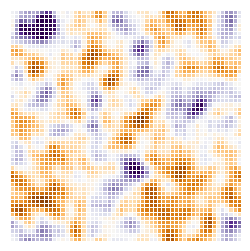

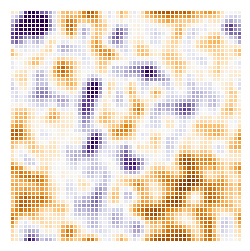

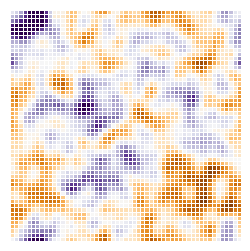

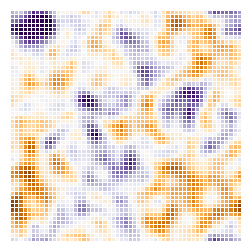

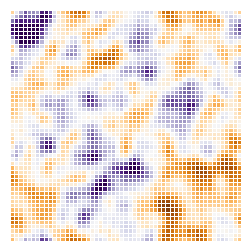

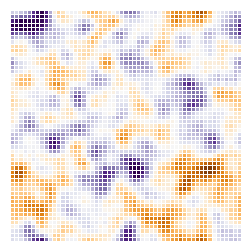

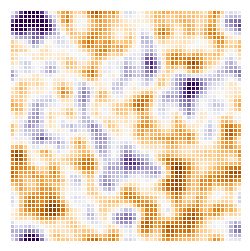

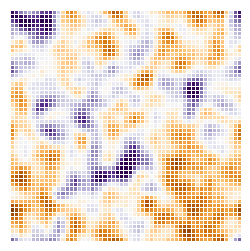

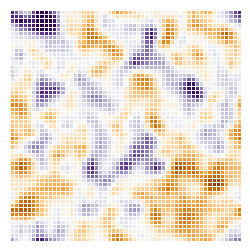

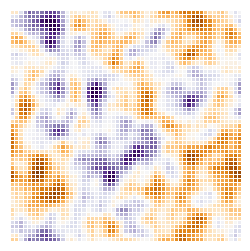

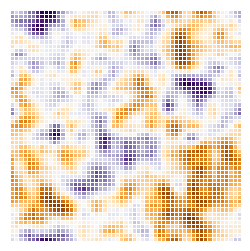

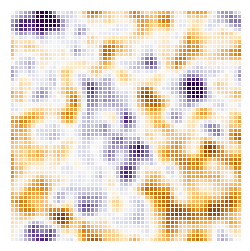

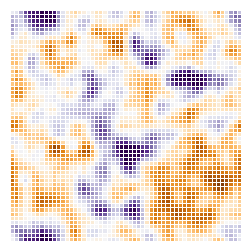

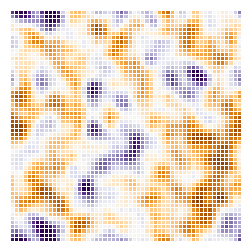

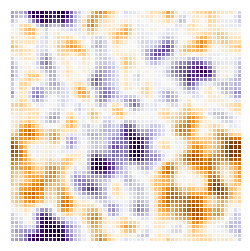

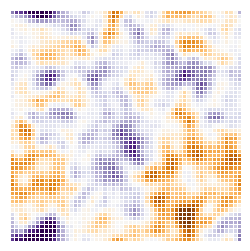

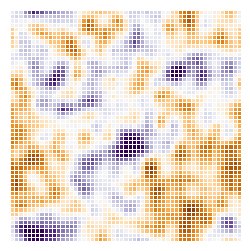

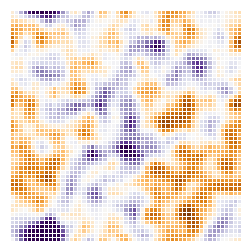

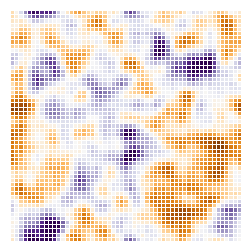

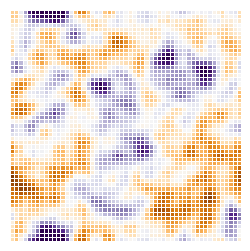

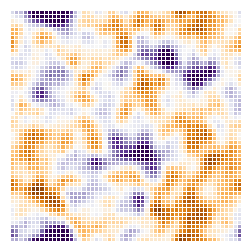

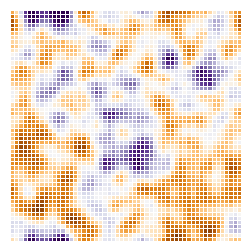

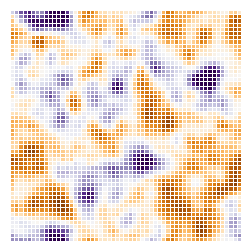

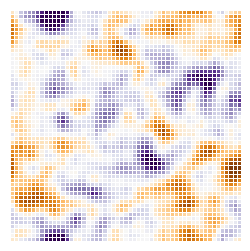

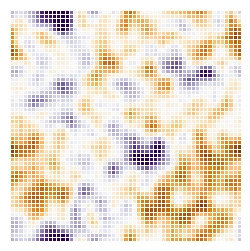

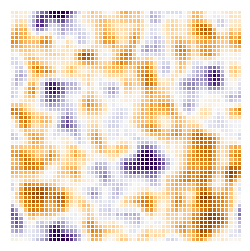

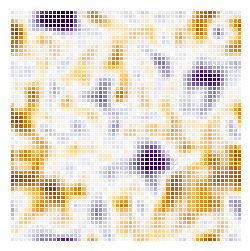

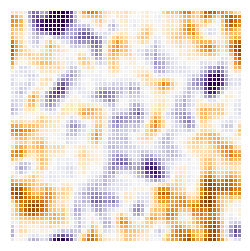

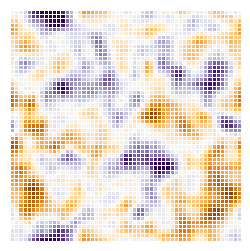

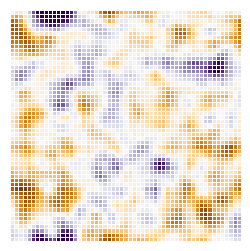

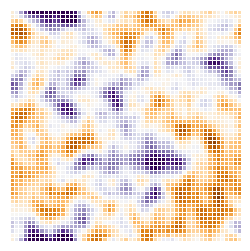

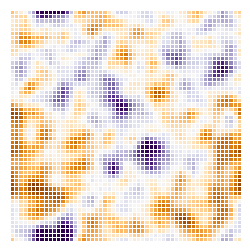

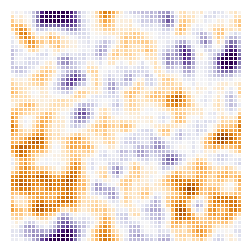

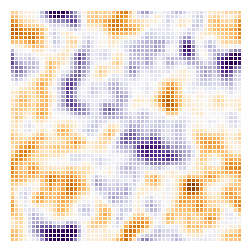

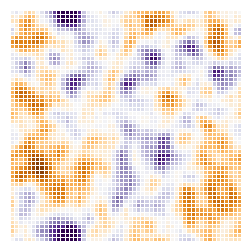

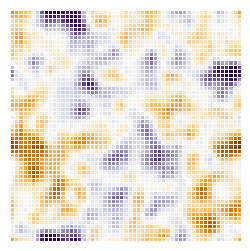

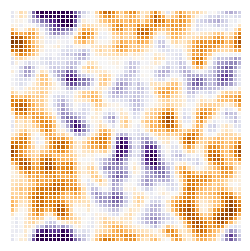

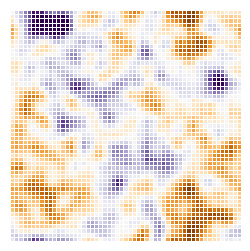

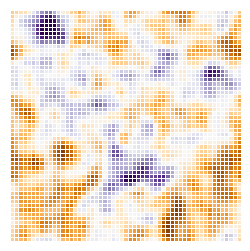

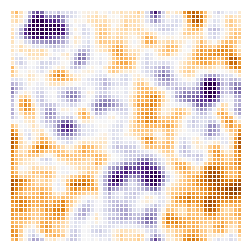

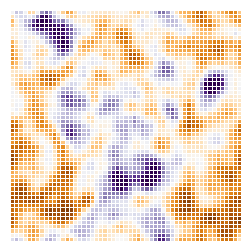

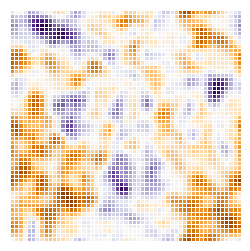

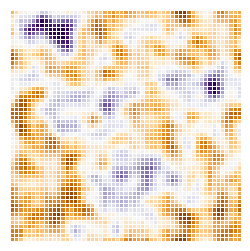

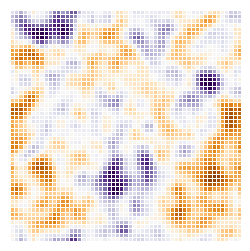

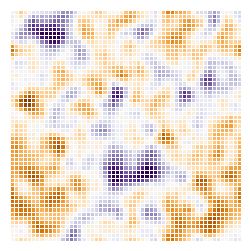

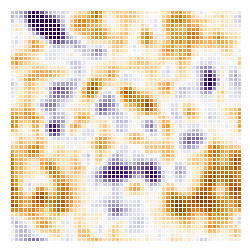

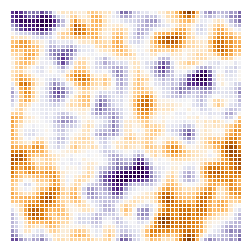

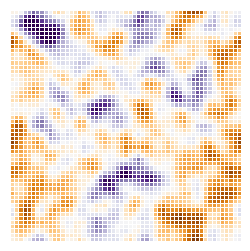

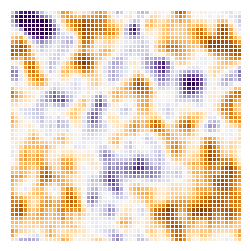

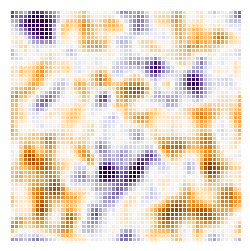

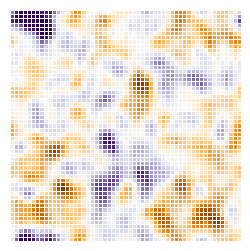

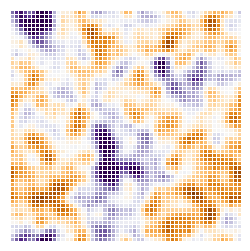

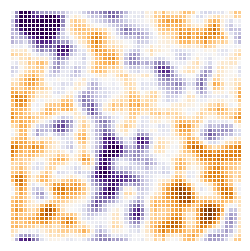

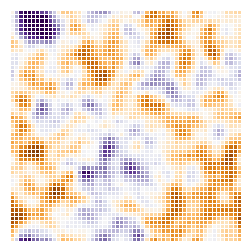

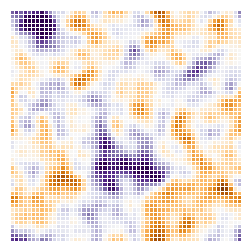

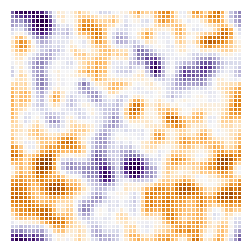

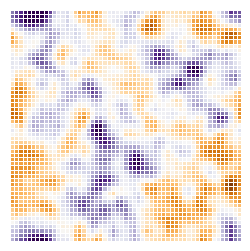

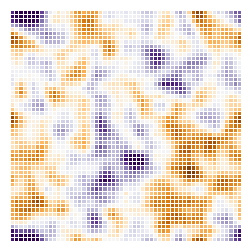

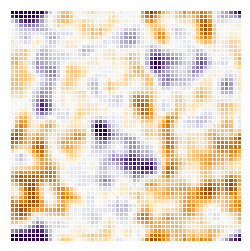

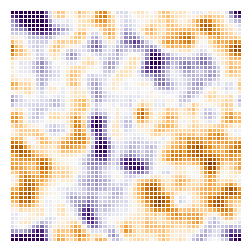

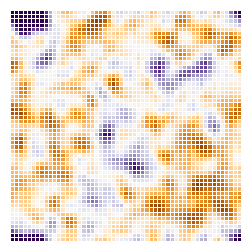

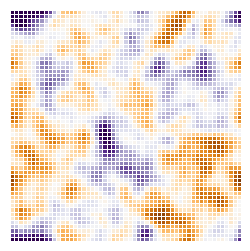

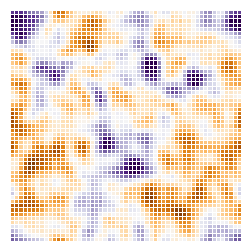

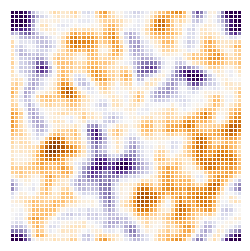

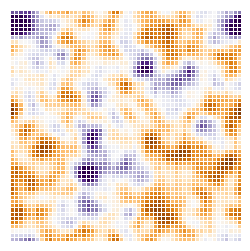

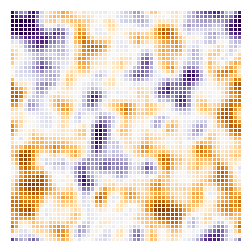

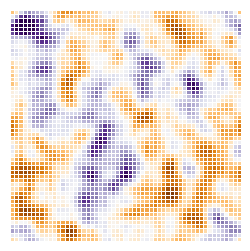

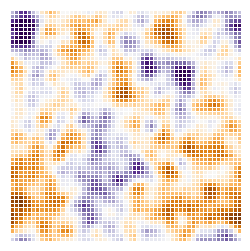

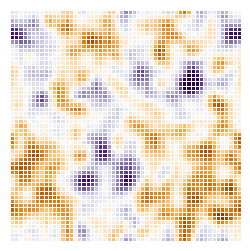

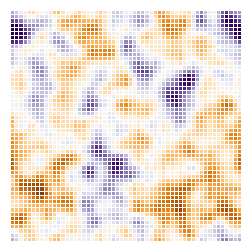

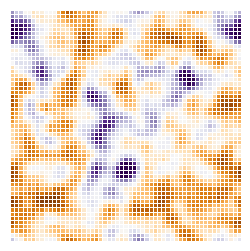

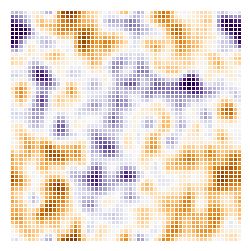

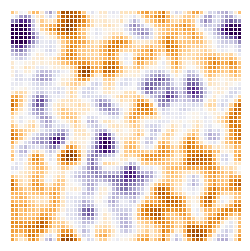

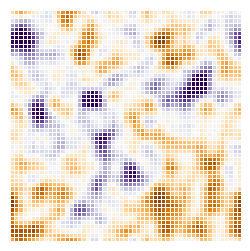

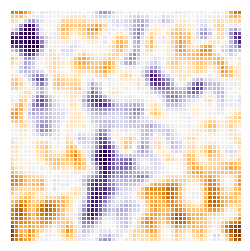

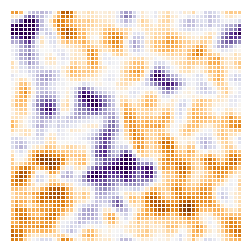

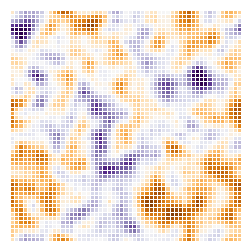

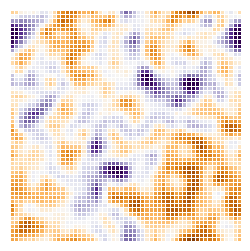

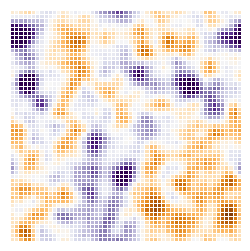

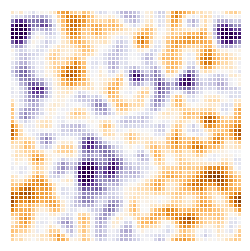

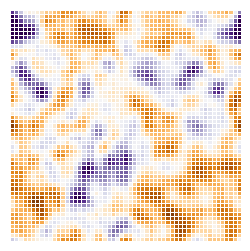

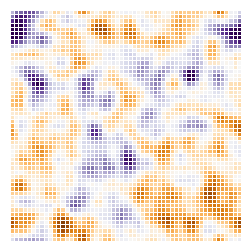

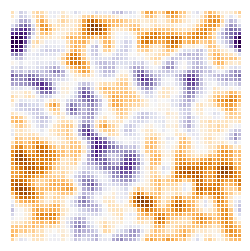

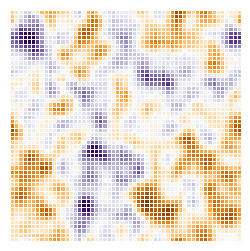

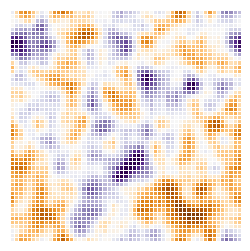

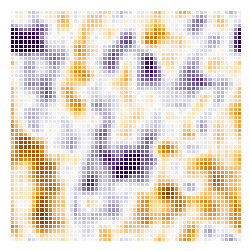

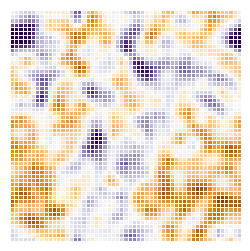

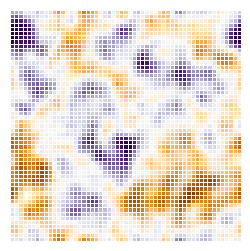

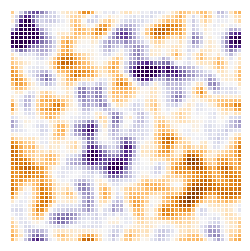

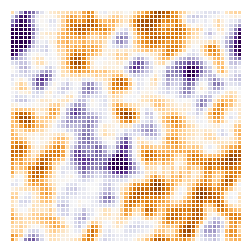

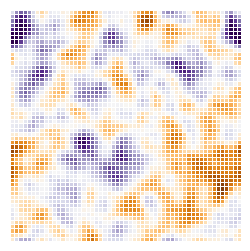

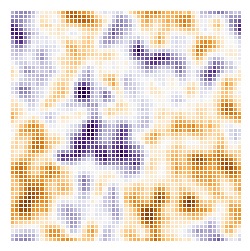

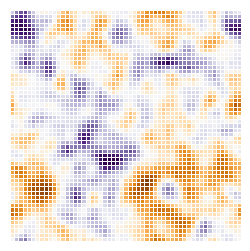

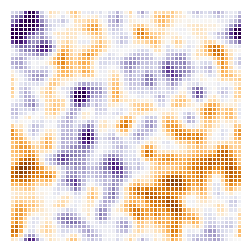

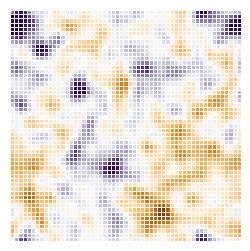

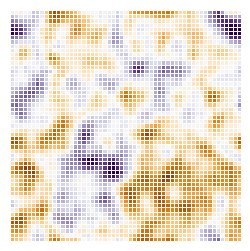

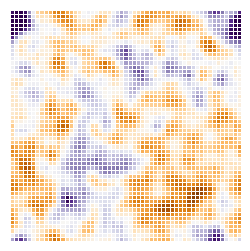

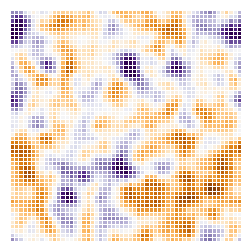

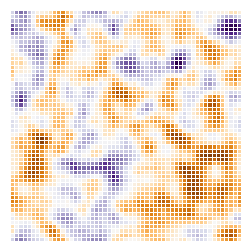

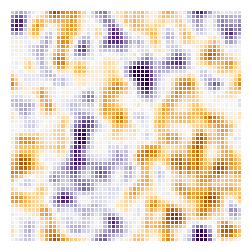

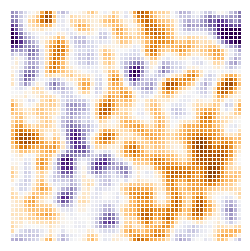

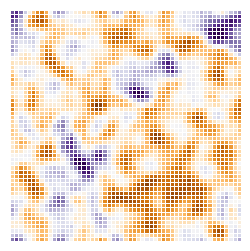

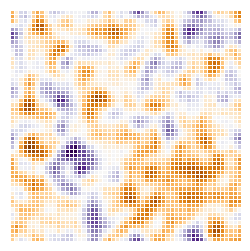

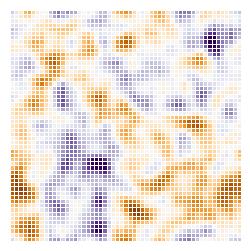

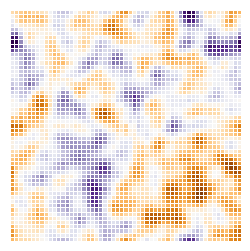

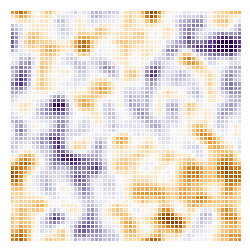

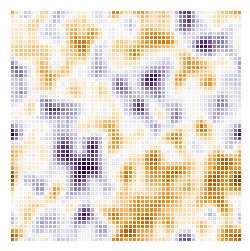

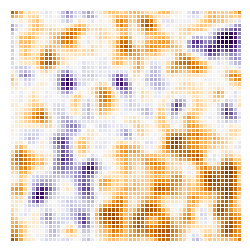

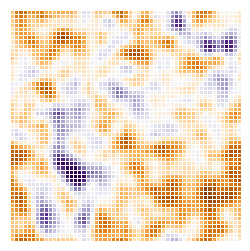

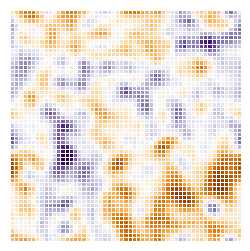

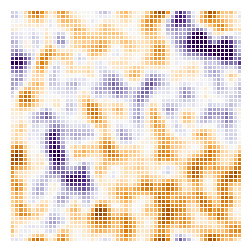

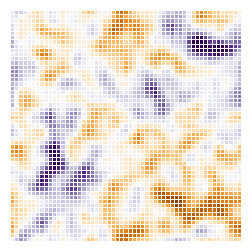

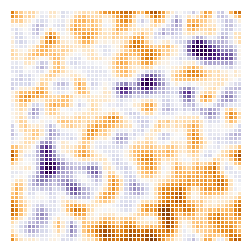

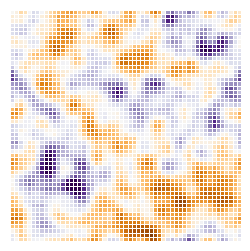

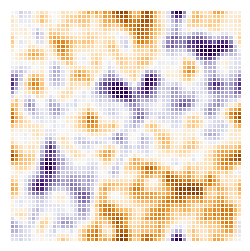

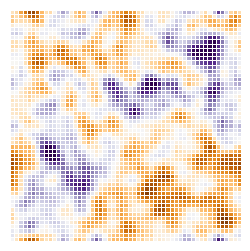

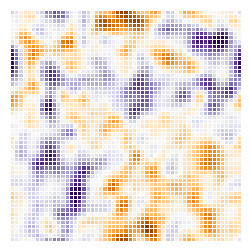

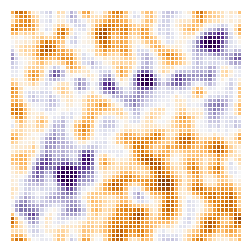

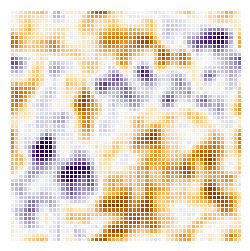

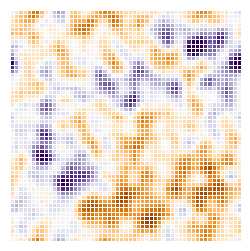

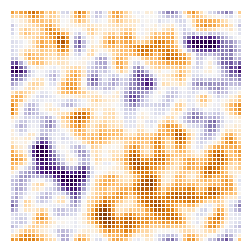

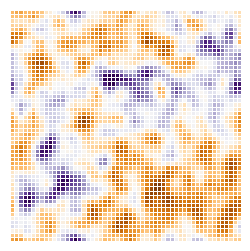

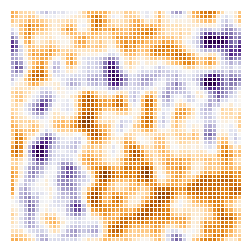

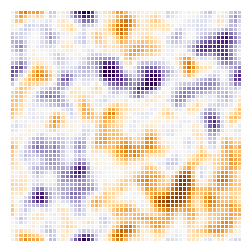

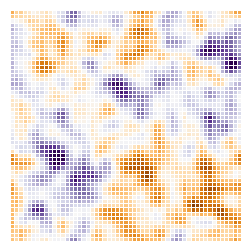

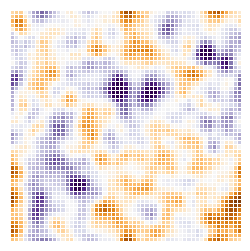

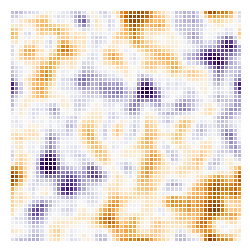

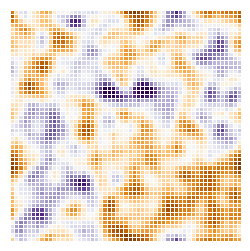

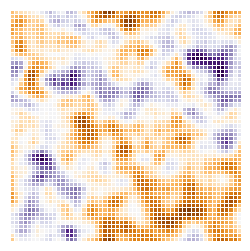

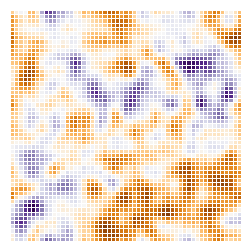

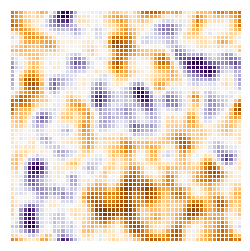

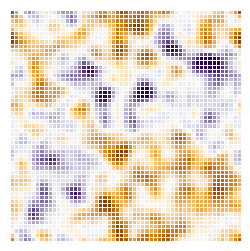

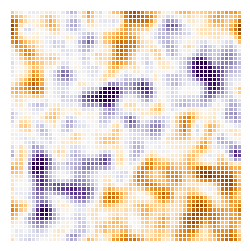

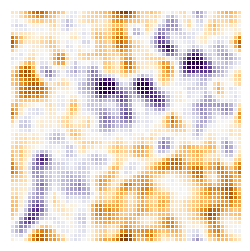

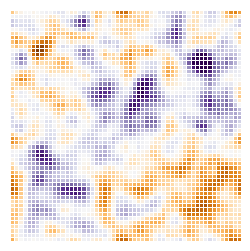

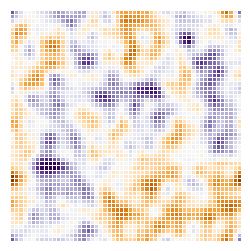

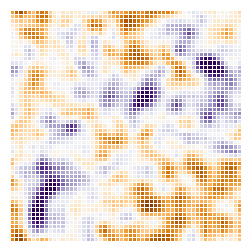

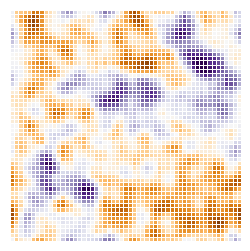

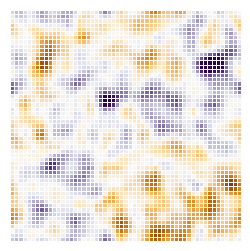

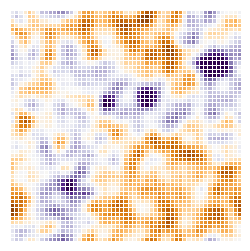

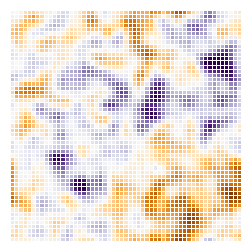

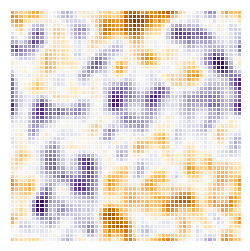

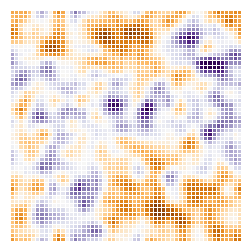

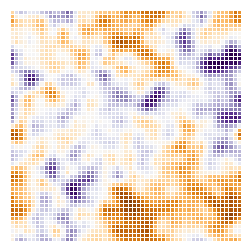

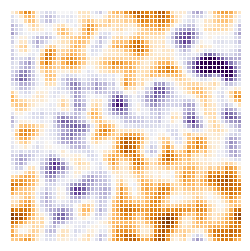

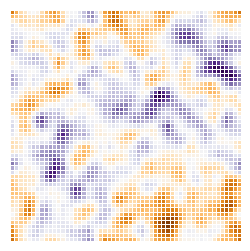

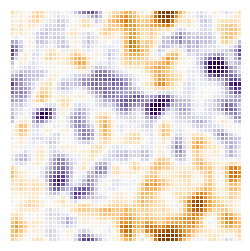

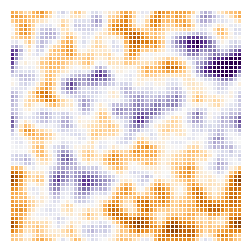

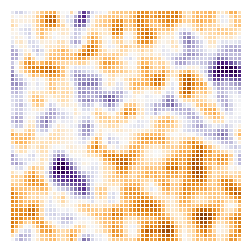

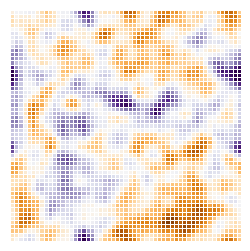

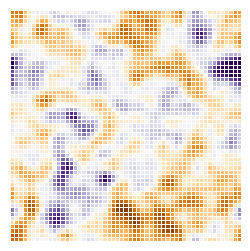

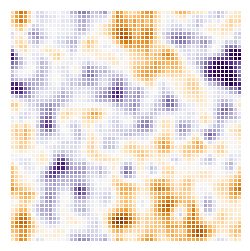

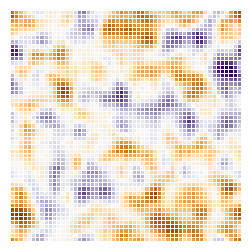

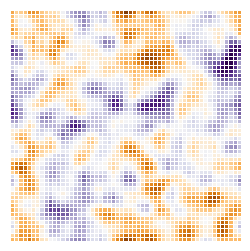

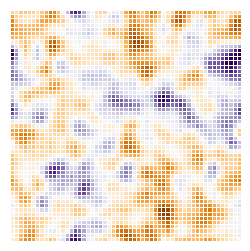

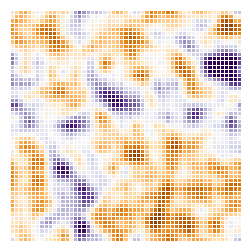

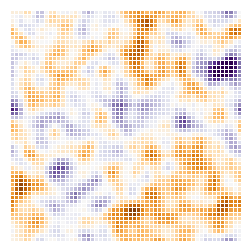

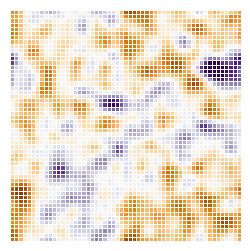

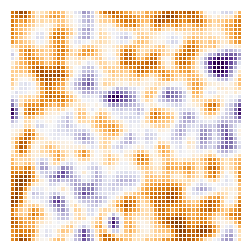

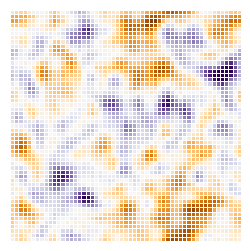

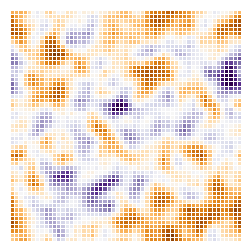

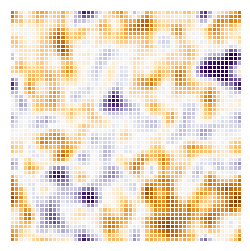

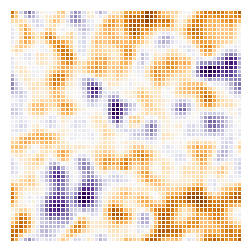

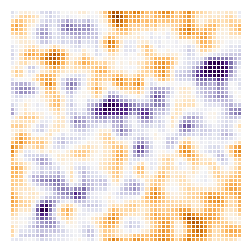

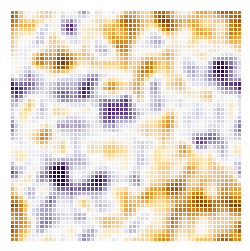

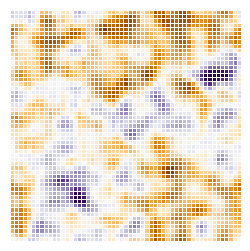

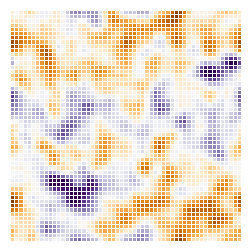

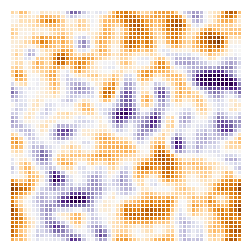

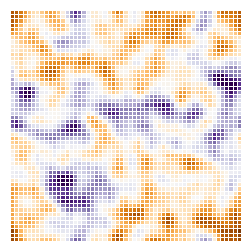

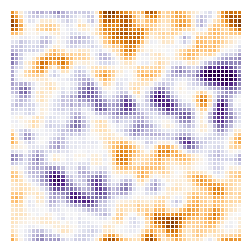

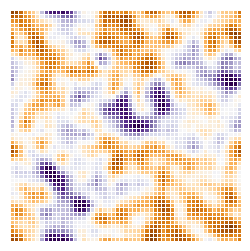

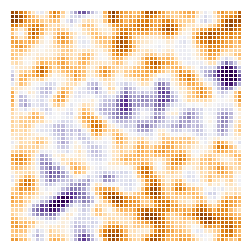

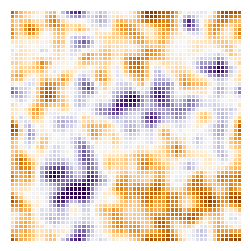

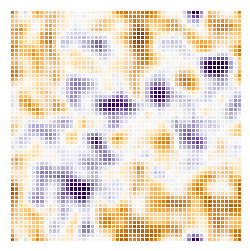

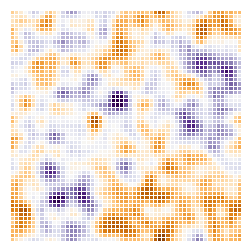

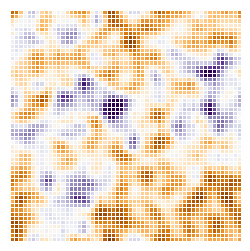

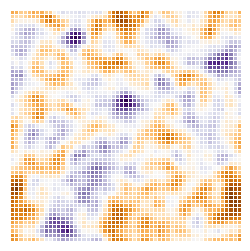

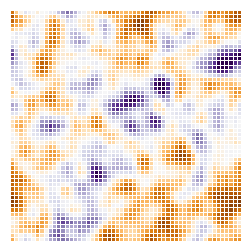

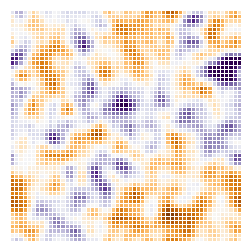

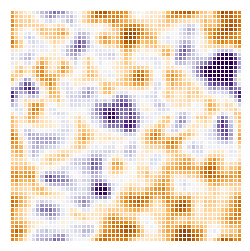

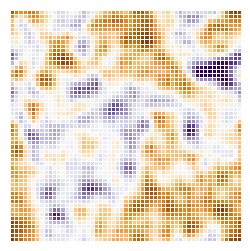

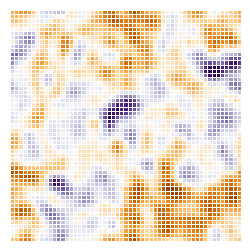

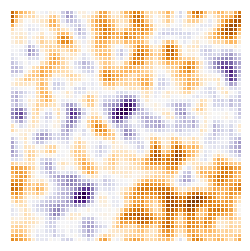

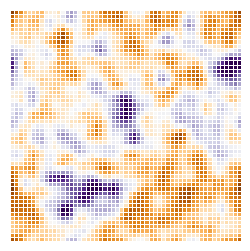

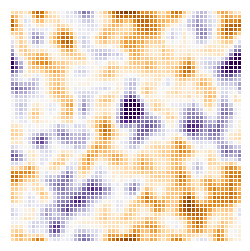

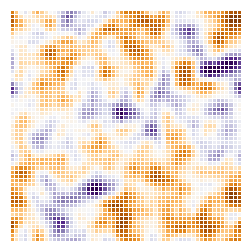

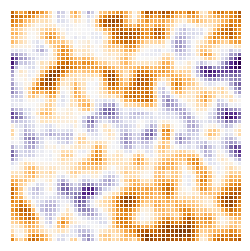

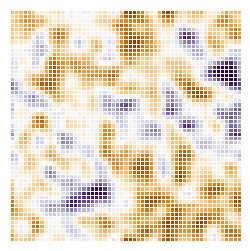

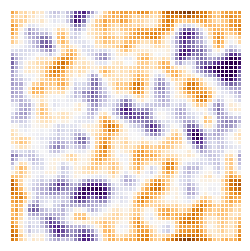

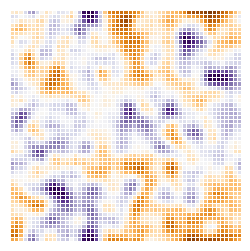

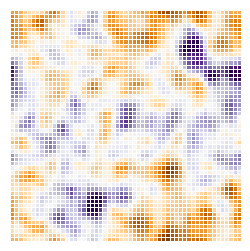

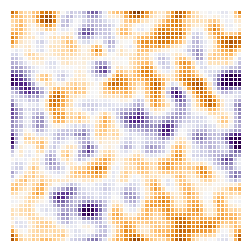

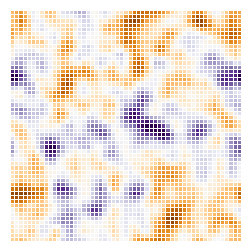

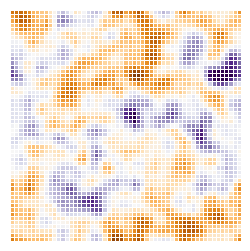

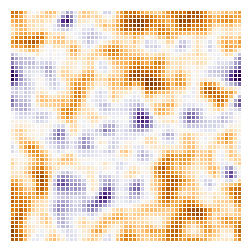

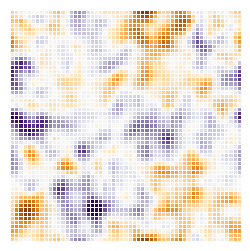

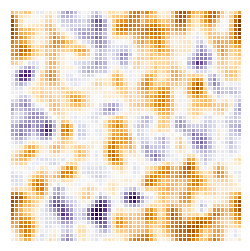

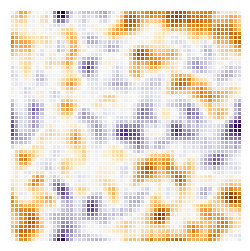

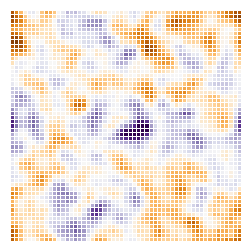

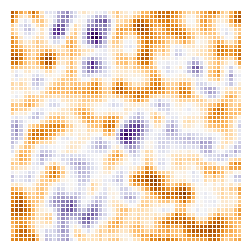

In [11]:
from scipy.ndimage import uniform_filter
import matplotlib
from copy import deepcopy
from matplotlib.ticker import LinearLocator

def plotDensmap_edge(data, edge):
	normData = deepcopy(data)
	print(normData.shape)
	
	normData = np.where (normData <1.1, normData, 1.1)           #dpdo + dpdochl
	normData = np.where (normData >0.9, normData, 0.9)
	levels = LinearLocator(numticks=10).tick_values(0.9, 1.1)

	# normData = np.where (normData <1.05, normData, 1.05)         #psmdopochl
	# normData = np.where (normData >0.95, normData, 0.95)
	# levels = LinearLocator(numticks=10).tick_values(0.95, 1.05)

	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.pcolormesh(yMatrix,
			 xMatrix, normData,
			 cmap=cmap, edgecolors='white', linewidth=0.4)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(0)
	densmap.spines['left'].set_linewidth(0)
	densmap.spines['top'].set_linewidth(0)
	densmap.spines['right'].set_linewidth(0)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
i=0
for h in h_atom_up_mean_all_normed_filtered:
	h_atom_list_after_filter = deepcopy(h)
	fig1 = plt.figure(figsize=(3, 3))#
	im = plotDensmap_edge(h, edge3d)   

	# cbar_ax = fig1.add_axes([0.20, 0.05, 0.64, 0.05]) 
	# cbar = fig1.colorbar(im, cax=cbar_ax, orientation='horizontal')

	# cbar.set_ticks([0.9, 1.1])          #dpdo + dpdochl
	# cbar.set_ticklabels(['0.9', '1.1'])

	# # cbar.set_ticks([0.95, 1.05])          #psmdopochl
	# # cbar.set_ticklabels(['0.95', '1.05'])
	# cbar.ax.tick_params(labelsize=14, direction='out')

	plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/tmp/'+sys+'-edge'+str(i)+'.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=False,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
	)
	i+=1

### write $\rho_{\text{norm}}$ into .xvg file

In [12]:
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/last1us/'+sys+'.xvg'
# 将 flattened_matrix 写入文件
with open(file_path, 'w') as file:
	if cal_ratio:
		for density, ratio in flattened_matrix:
			print(density, ratio, file=file)
	else:
		for density in flattened_matrix:
			print(str(float(density)), file=file)
print(f"Data written to {file_path}")

Data written to /data/gulab/yzdai/data4/phase_identification/plot/input/last1us/dpdochl290k.xvg


# Plot

In [22]:
def plotRpsmap(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1, normData, 1)
	normData = np.where (normData >0, normData, 0)
	normData = np.where (np.isnan(data), np.nan, normData)
	levels = LinearLocator(numticks=10).tick_values(0, 1)
	cmap = plt.get_cmap('PiYG')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap, shading='auto')#, edgecolors='w', linewidth=0.5
	
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	
	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	cbar.set_ticks([0, 1])  # 设置 colorbar 的刻度为首尾
	cbar.set_ticklabels(['0', '1'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.show()
	return im
def plotDensmap_with_nan(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1.1, normData, 1.1)
	normData = np.where (normData >0.95, normData, 0.95)
	normData = np.where (np.isnan(data), np.nan, normData)

	# levels = LinearLocator(numticks=7).tick_values(0.8, 1.5)
	levels = LinearLocator(numticks=10).tick_values(0.95, 1.1)
	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	# cbar.set_ticks([0.95, 1.1])  # 设置 colorbar 的刻度为首尾
	# cbar.set_ticklabels(['0.95', '1.1'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.show()
	return im
def plotDensmap_pure_phospholipid(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1.04, normData, 1.04)
	normData = np.where (normData >0.97, normData, 0.97)
	normData = np.where (np.isnan(data), np.nan, normData)

	plt.figure(figsize=(3,2))
	# levels = LinearLocator(numticks=7).tick_values(0.8, 1.5)
	levels = LinearLocator(numticks=10).tick_values(0.97, 1.04)
	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, \
				levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值

	cbar.set_ticks([0.97, 1.04])  # 设置 colorbar 的刻度为首尾
	cbar.set_ticklabels(['0.97', '1.04'])  # 定义刻度标签
	
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	plt.tight_layout()
	# 显示图像
	plt.savefig(
		"/data/gulab/yzdai/data4/phase_identification/plot/output/densmap/"+sys+"_densmap.png",        # 文件名
		dpi=350,             # 分辨率
		format='png',        # 文件格式
		bbox_inches='tight', # 自动调整边界框
		pad_inches=0.0,      # 边界填充
		# facecolor='white',   # 背景颜色
		# edgecolor='black',   # 边缘颜色
		transparent=False,   # 是否透明背景
		# metadata={'Author': 'Your Name'}  # 元数据
	)
	return im

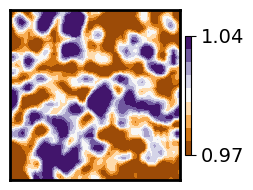

In [23]:
%matplotlib inline
h = h_atom_up_mean_all_normed_filtered[-1]
im = plotDensmap_pure_phospholipid(h, edge3d) 
# im = plotDensmap_with_nan(h, edge3d) 

### load $\rho_{\text{norm}}$ (optional)

In [25]:
# sys='dpdo280k'
# sys='dpdo290k'
# sys='dpdochl280k'
sys='dpdochl290k'
# sys='psmdopochl'
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/last1us/'+sys+'.xvg'
with open(file_path, 'r') as file:
	flattened_matrix = np.loadtxt(file)
flattened_matrix = flattened_matrix.reshape(-1,1)
print(flattened_matrix.shape)

(1210000, 1)


# GMM model

In [29]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="sklearn")
def get_gmm_threshold(data_1d, plot=True):
	X = data_1d[~np.isnan(data_1d)].reshape(-1, 1)
	gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
	gmm.fit(X)

	means = gmm.means_.flatten()
	stds = np.sqrt(gmm.covariances_.flatten())
	weights = gmm.weights_.flatten()

	if means[0] > means[1]:
		means = means[::-1]
		stds = stds[::-1]
		weights = weights[::-1]

	try:
		def f(x): return weights[0]*norm.pdf(x, means[0], stds[0]) - weights[1]*norm.pdf(x, means[1], stds[1])
		intersection = brentq(f, means[0], means[1])
	except:
		intersection = np.mean(means)  # fallback

	candidates = {
		"intersection": intersection,
		"mean": np.mean(means),
		"weighted": np.dot(means, weights),
		"hybrid": 0.5 * intersection + 0.5 * np.dot(means, weights)
		# "hybrid": 0.5 * intersection + 0.5 * np.mean(means)
	}

	if plot:
		x = np.linspace(X.min(), X.max(), 1000)
		p0 = weights[0] * norm.pdf(x, means[0], stds[0])
		p1 = weights[1] * norm.pdf(x, means[1], stds[1])
		total = p0 + p1

		plt.figure(figsize=(7,4))
		plt.hist(X, bins=100, density=True, alpha=0.2, \
		   label='Histogram', color='gray')
		plt.plot(x, p0, linewidth = 3, \
		   label=rf"$P_{{\mathrm{{Ld}}}}(v)$", \
		#    label = rf"Ld" + rf"($\mu={means[0]:.3f}$, $\sigma={stds[0]:.3f}$)", \
			color='#B22222')

		plt.plot(x, p1, linewidth = 3, \
		   label=rf"$P_{{\mathrm{{Lo}}}}(v)$", \
		#    label=rf"{'Lo'} ($\mu={means[1]:.3f}$, $\sigma={stds[1]:.3f}$)", \
		   color='#1f77b4')
		plt.plot(x, total, linewidth = 3, \
		   label=rf"$P(v)$", color='gray')

		for k, v in candidates.items():
			if(k == 'hybrid'):
				plt.axvline(v, linestyle='--', linewidth = 3, color = 'k',\
				alpha=1, label = rf"$v_{{\mathrm{{hybrid}}}}$={v:.4f}")

		plt.xlim(0.9, 1.2)
		plt.xticks(np.arange(0.9, 1.21, 0.1), fontsize=25)
		plt.ylim(0, 14)
		plt.yticks(np.arange(4, 15, 4), fontsize=25)
		
		plt.tick_params(direction='in', width=3)
		# plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
		plt.xlabel("Normed Atomic Density", fontsize = 25)
		plt.ylabel("Probability Density", fontsize = 25)

		plt.legend(fontsize=25, frameon = False,
					loc='upper right', 
					bbox_to_anchor=(1.08,1.05), 
					labelspacing=0.05,    
					handlelength=1.2,   
					handletextpad=0.5     
					)
		plt.grid(False)
	
		plt.tight_layout()
		ax = plt.gca()
		ax.spines['top'].set_visible(False) 
		ax.spines['right'].set_visible(False) 
		# ax.spines['left'].set_linewidth(False)
		# ax.spines['bottom'].set_linewidth(False)
		ax.spines['left'].set_linewidth(3)
		ax.spines['bottom'].set_linewidth(3)
		
		plt.savefig("/data/gulab/yzdai/data4/phase_identification/plot/output/threshold_tuning/"+sys+"_threshold.png", dpi=300)

	return candidates


{'intersection': 1.0133639145246656, 'mean': 1.0036209378162955, 'weighted': 0.9999999998338843, 'hybrid': 1.0066819571792749}


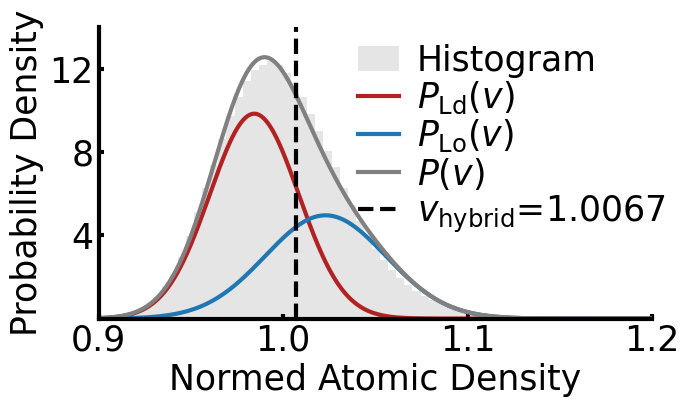

In [30]:
candidates = get_gmm_threshold(flattened_matrix[:, 0])
print(candidates)

### $\theta = v_\text{hybrid} = \alpha \times v_\text{int} + (1-\alpha) \times v_\text{weighted}$ 

In [31]:
initial_threshold = candidates['hybrid']
print("Initial threshold", initial_threshold)

Initial threshold 1.0066819571792749


# Visualisation-guided fine-tuning

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import gridspec
import matplotlib as mpl
mpl.use('Agg')
def plot_map(tag_matrix, edge, points, points_type, threshold, lo_ratio, p_adj_lo=None):
	points = np.array(points)
	# print(points.shape)
	cmap = ListedColormap([
				(177/255, 24/255, 43/255),    # 红
				(223/255, 118/255, 94/255), # 橘
				(1,1,1), #white
				(92/255, 163/255, 203/255), # 浅蓝
				(32/255, 101/255, 171/255),   # 蓝
			])

	levels = [0.0, 0.20, 0.30, 0.70, 0.8, 1.0]  # 任意，只要能将两个值分开就行

	# 构建 BoundaryNorm：用于让 contourf 不插值，严格两个颜色
	norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

	xMatrix = np.zeros((tag_matrix.shape[0], tag_matrix.shape[1]))
	yMatrix = np.zeros((tag_matrix.shape[0], tag_matrix.shape[1]))
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, tag_matrix.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, tag_matrix.shape[1]):
		yMatrix[:, j] = yaxis
		
	# 新建图像
	fig, ax = plt.subplots(figsize=(3, 4))
	ax.contourf(yMatrix, xMatrix, tag_matrix, levels=levels, cmap=cmap, norm=norm)
	# 半透明遮罩（覆盖整个图）
	ax.fill_between(
		x=[yaxis.min(), yaxis.max()],
		y1=xaxis.min(),
		y2=xaxis.max(),
		color='white',
		alpha=0.3,
		zorder=2
	)
	# 点
	# 自定义颜色映射
	type_to_color = {
		'DPPC': (66/255, 165/255, 245/255),
		'DOPC': (239/255, 83/255, 80/255),
		'CHL1': (255/255, 202/255, 40/255),
		'PSM':  (66/255, 165/255, 245/255),
		'POPC': (102/255, 187/255, 106/255),
	}

	# 构建颜色数组
	colors = [type_to_color[t] for t in points_type]
	# 点绘制
	ax.scatter(points[:,0],points[:,1],
			   c=colors,
			   s=15, marker='o', linewidths=0.5,
			   zorder=3)

	# 样式设置
	ax.set_aspect(1)
	# for side in ['bottom', 'left', 'top', 'right']:
	# 	ax.spines[side].set_linewidth(2)
	for spine in ax.spines.values():
		spine.set_visible(False)

	ax.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	# ----- 图标题和注释 -----
	# 顶部标题：阈值
	ax.text(0.5, 1.03, f"Threshold = {threshold:.4f}", transform=ax.transAxes,
			ha='center', va='bottom', fontsize=15, fontweight='bold')

	ax.text(0.5, -0.05, fr"$\mathrm{{Ratio}}_{{Lo}}$: {lo_ratio:.4f}", transform=ax.transAxes,
			ha='center', va='top', fontsize=15)

	p_adj_text = fr"$P_{{adj}}$: {p_adj_lo:.4f}" if p_adj_lo is not None else "$P_{adj}$: -"
	ax.text(0.5, -0.15, p_adj_text, transform=ax.transAxes,
			ha='center', va='top', fontsize=15)
	plt.close(fig)
	return fig

def calculate_adjusted_probabilities(C_A, N_A, C_B, N_B):
	"""
	计算胆固醇出现在两类脂质中的调整后概率
	
	参数:
	C_A (int): 类别A中胆固醇的数量
	N_A (int): 类别A中脂质的总数
	C_B (int): 类别B中胆固醇的数量
	N_B (int): 类别B中脂质的总数
	
	返回:
	tuple: (P_adj_A, P_adj_B) 分别为胆固醇出现在类别A和类别B的调整后概率
	"""
	
	# 计算原始频率
	P_prime_A = C_A / N_A
	P_prime_B = C_B / N_B
	
	# 计算先验概率
	P_A = N_A / (N_A + N_B)
	P_B = N_B / (N_A + N_B)
	
	# 计算调整后的概率
	denominator = P_prime_A * P_A + P_prime_B * P_B
	P_adj_A = (P_prime_A * P_A) / denominator
	P_adj_B = 1 - P_adj_A  # 或者 (P_prime_B * P_B) / denominator
	
	# print("CHOL Lo:",P_adj_A,"CHOL Ld:",P_adj_B)
	return P_adj_A, P_adj_B
def process_threshold(u, threshold, flattened_matrix, chol_id=None):
	# 1. 阈值分类
	tags = np.where(list(flattened_matrix[:,0]) > threshold, 1, 0)
	split_idx = len(tags) // 2
	tag_matrixs_up = tags[:split_idx].reshape(n_t, n_x, n_y)
	tag_matrixs_low = tags[split_idx:].reshape(n_t, n_x, n_y)

	# 2. 获取每分子的标签，并时间平滑
	lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)  # list of list
	lips_tag = np.array(lips_tag)                      # shape: (n_t, n_lipids)
	lips_tag_smoothed = temporal_smoothing(lips_tag)   # shape unchanged
	
	all_tags = np.array(lips_tag_smoothed)  # shape: (n_t, n_lipids)
	N_A = np.sum(all_tags == 1)   # Lo 总数
	N_B = np.sum(all_tags == 0)   # Ld 总数
	lo_ratio = N_A/(N_A + N_B)
	if chol_id is not None:
		# Chol 统计
		# Chol IDs 是 chol_id（如 [1, 4, 28, ...]）
		chol_ndx = np.array(chol_id) - 1 
		chol_tags = all_tags[:, chol_ndx]  # shape: (n_t, n_chol)
		C_A = np.sum(chol_tags == 1)      # chol 在 Lo 的次数
		C_B = np.sum(chol_tags == 0)      # chol 在 Ld 的次数
		p_adj_lo, p_adj_ld = calculate_adjusted_probabilities(C_A, N_A, C_B, N_B)
	else: 
		p_adj_lo = None
	# 3. 提取每个脂质的质心并画图
	ts = u.trajectory[end-5]
	
	fr_leaflets = lip_leaflet_raw[end-5:end, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fr_leaflets)]
	upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
	lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
	sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
	sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)

	upper_atoms = u.select_atoms(sel_atom_upper)
	lower_atoms = u.select_atoms(sel_atom_lower)
	# 按 resid 分组
	upper_res_groups = upper_atoms.residues
	lower_res_groups = lower_atoms.residues

	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])
	
	# 提取上片
	upper_coms_raw = [res.atoms.center_of_mass() for res in upper_res_groups]
	upper_coms = np.add(np.array(upper_coms_raw), diffnp)
	upper_coms = [com[:2] for com in upper_coms]
	upper_types = [res.resname for res in upper_res_groups]

	# 提取下片
	lower_coms_raw = [res.atoms.center_of_mass() for res in lower_res_groups]
	lower_coms = np.add(np.array(lower_coms_raw), diffnp)
	lower_coms = [com[:2] for com in lower_coms]
	lower_types = [res.resname for res in lower_res_groups]


	fig = plot_map(tag_matrixs_up[-1], edge3d, upper_coms, upper_types, threshold, lo_ratio, p_adj_lo)
	plt.close(fig)

	return (threshold, fig)

lower_thresholds = np.linspace(initial_threshold - 0.005, initial_threshold, 6)[:-1] 
upper_thresholds = np.linspace(initial_threshold, initial_threshold + 0.005, 6)[1:] 
thresholds = np.concatenate([lower_thresholds, [initial_threshold], upper_thresholds]) 

with parallel_backend("threading", n_jobs=5):
    results = Parallel()(
        delayed(process_threshold)(u, t, flattened_matrix, chol_id=chol_id)
        for t in tqdm(thresholds)
    )

def fig_to_array(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return np.array(Image.open(buf))

img_arrays = [fig_to_array(f) for _, f in results]

fig_big = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 7, figure=fig_big)

ax_initial = fig_big.add_subplot(gs[0:2, 0:2]) 
ax_initial.imshow(img_arrays[5])  # initial threshold 
ax_initial.axis('off')
# ax_initial.set_title(f"t={thresholds[5]:.4f}", fontsize=10)


for i, ax in enumerate([fig_big.add_subplot(gs[0, 2 + j]) for j in range(5)]): 
    ax.imshow(img_arrays[i])
    ax.axis('off')
    # ax.set_title(f"t={thresholds[i]:.4f}", fontsize=10)

for i, ax in enumerate([fig_big.add_subplot(gs[1, 2 + j]) for j in range(5)]):  
    ax.imshow(img_arrays[6 + i])
    ax.axis('off')
    # ax.set_title(f"t={thresholds[6 + i]:.4f}", fontsize=10)


plt.tight_layout()

plt.savefig("/data/gulab/yzdai/data4/phase_identification/plot/output/threshold_tuning/"+sys+"_threshold_grid_map2.png", dpi=300)


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


# Choose the best threshold $\theta^*$

In [34]:
best_threshold = thresholds[5]
print("Best threshold", best_threshold)


Best threshold 1.0066819571792749


# Classify pixels according to threshold $\theta^*$ and assign a phase state to each lipid

In [49]:
if (param == 'None'):
	output_data = {}
	output_data['density'] = {
			"mean":density_mean
		}
	output_data['phase'] = {
			"threshold": best_threshold
		}
	# print(output_data['phase'])
	with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'parameters.json'), 'w') as json_file:
		json.dump(output_data, json_file, indent=4)
else:
	with open(param, 'r') as json_file:
		params = json.load(json_file)
	best_threshold = params['phase']['threshold']

	
tags = np.where(np.array(list(flattened_matrix[:,0])) > best_threshold, 1, 0)

split_idx = len(tags) // 2
tag_matrixs_up = tags[:split_idx].reshape(n_t, n_x, n_y)
tag_matrixs_low = tags[split_idx:].reshape(n_t, n_x, n_y)

lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)

print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')

end of phase identification
shape of lips_tag:	 (200, 1152)
---------------------------------

